In [10]:
# --- Imports ---
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Paths ---
NC_PATH = Path("../data/processed/chla_caspian_2021Q2.nc")  # relative to notebook folder

# Map extent for Caspian (W, E, S, N)
WEST, EAST, SOUTH, NORTH = 46.0, 54.0, 42.0, 48.0

# --- Load dataset ---
ds_3mo = xr.open_dataset(NC_PATH)

print("Loaded dataset:", NC_PATH)
print(ds_3mo)

Loaded dataset: ../data/processed/chla_caspian_2021Q2.nc
<xarray.Dataset> Size: 6MB
Dimensions:  (time: 55, lat: 144, lon: 192)
Coordinates:
  * lat      (lat) float32 576B 42.02 42.06 42.1 42.15 ... 47.9 47.94 47.98
  * lon      (lon) float32 768B 46.02 46.06 46.1 46.15 ... 53.9 53.94 53.98
  * time     (time) datetime64[ns] 440B 2021-04-01 2021-04-02 ... 2021-05-31
Data variables:
    chlor_a  (time, lat, lon) float32 6MB ...


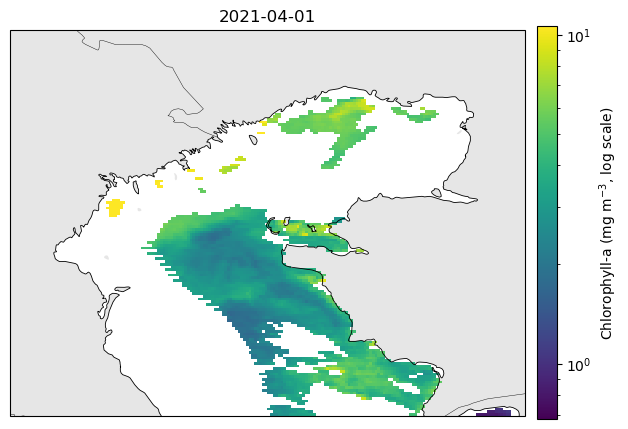

In [12]:
# Select chlorophyll-a variable from the dataset
da = ds_3mo["chlor_a"]

# Cast to float64 and mask invalid / non-positive values (LogNorm requires >0)
da = da.astype("float64")
da = da.where(np.isfinite(da) & (da > 0))

# Convert to NumPy for animation frames (shape: time × lat × lon)
frames = da.to_numpy()

# Build spatial grid for plotting
lon = da.coords["lon"].to_numpy()
lat = da.coords["lat"].to_numpy()
LON, LAT = np.meshgrid(lon, lat)

# Determine color scale limits from data percentiles (robust against outliers)
valid = frames[np.isfinite(frames)]
if valid.size == 0:
    raise ValueError("All values are invalid or ≤0 after cleaning; check the crop/time window.")

vmin = max(np.nanpercentile(valid, 5), 0.03)      # lower bound (>= 0.03)
vmax = min(max(np.nanpercentile(valid, 95), vmin*5), 30.0)  # upper bound (<= 30)

# --- Set up figure and map ---
fig = plt.figure(figsize=(8, 6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)

# Initial frame (logarithmic color scale)
im = ax.pcolormesh(
    LON, LAT, frames[0], transform=proj,
    cmap="viridis", norm=LogNorm(vmin=vmin, vmax=vmax), shading="auto"
)

# Add map features
ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="none")
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.set_extent([WEST, EAST, SOUTH, NORTH], crs=proj)

# Colorbar
cb = fig.colorbar(im, ax=ax, pad=0.02, shrink=0.85)
cb.set_label("Chlorophyll-a (mg m$^{-3}$, log scale)")

# Time axis for titles
dates = da.coords["time"].to_numpy()
ttl = ax.set_title(str(np.datetime_as_string(dates[0], unit="D")))

# Animation update function: swap data and update title
def update(i):
    im.set_array(frames[i].ravel())
    ttl.set_text(str(np.datetime_as_string(dates[i], unit="D")))
    return im, ttl

# Run animation
ani = FuncAnimation(fig, update, frames=len(dates), interval=300, blit=False)

# Display interactively in notebook
HTML(ani.to_jshtml())